In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from models.base import Base
from sklearn.cross_validation import train_test_split

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
if os.path.exists('../data/X.npy'):
    dataset = np.load('../data/X.npy')
    targets = np.load('../data/targets.npy')
else:
    noise = np.load('../../The-Quest-For-Mu/noise200_200.npy')
    artificial_tracks = np.load('../../The-Quest-For-Mu/convolves2.npy')
    
    def gen_big_pictures_dataset(tracks, noise, size, tracks_count, shape=(200, 200)):
        assert(len(shape) == 2)
        assert(shape[0] == shape[1])

        dataset = []
        targets = []

        past_time = time.time()
        for j in xrange(size):
            if j % 100 == 0:
                print(j, time.time() - past_time)
                past_time = time.time()

            template = np.zeros(shape)
            answer = np.zeros(shape)
            noise_template = noise[np.random.choice(np.arange(noise.shape[0]))].reshape(200, 200)
            signal_samples = artificial_tracks[np.random.choice(np.arange(artificial_tracks.shape[0]),
                                                                replace=False,
                                                                size=tracks_count)]

            if tracks_count > 0:
                tlx = np.random.choice(np.arange(shape[0] - signal_samples[0].shape[0]),
                                       replace=False,
                                       size=tracks_count)
                tly = np.random.choice(np.arange(shape[1] - signal_samples[0].shape[1]),
                                       replace=False,
                                       size=tracks_count)

            for i in xrange(tracks_count):
                answer[tlx[i]:tlx[i] + signal_samples[0].shape[0],\
                       tly[i]:tly[i] + signal_samples[0].shape[1]] = (signal_samples[i] > 0).astype(np.int8)
                template[tlx[i]:tlx[i] + signal_samples[0].shape[0],\
                         tly[i]:tly[i] + signal_samples[0].shape[1]] = signal_samples[i]


            sample = np.max([5 * template / (1e-6 + template.max() - template.min()),
                             6 * noise_template / (1e-6 + noise_template.max() - noise_template.min())],
                            axis=0)

            dataset.append(sample.ravel())
            targets.append(answer.ravel())

        return np.vstack(dataset), np.vstack(targets)
    
    
    dataset, targets = gen_big_pictures_dataset(artificial_tracks, noise, 10000, 3)

In [47]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]
        
        
def downscale(targets, window=20):
    new_shape = targets[0].shape[-1] / window
    results = np.zeros((0, new_shape, new_shape))

    for target in targets:
        result = np.zeros((new_shape, new_shape))
        for xs in range(new_shape):
            for ys in range(new_shape):
                result[xs, ys] = target[xs * window:(xs + 1) * window, ys * window:(ys + 1) * window].max()

        results = np.vstack((results, result.reshape(1, new_shape, new_shape)))

    return results


def learn(nn, dataset, num_epochs=100, batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    
    X_train, X_val, y_train, y_val = dataset

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        train_pos_error = 0
        start_time = time.time()

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_pos_error_batch, train_acc_batch = nn.train(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_pos_error += train_pos_error_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        val_pos_error = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_pos_error_batch, val_acc_batch = nn.evaluate(inputs, targets)
            val_acc += val_acc_batch
            val_pos_error += val_pos_error_batch
            val_batches += 1

        # Then we print the results for this epoch:
        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        print('  training loss (in-iteration):\t\t\t{:.6f}'.format(train_err / train_batches))
        print('  train accuracy:\t\t{:.2f} %'.format(train_acc / train_batches * 100))
        print('  train recall:\t\t\t{:.2f} %'.format(train_pos_error / train_batches * 100))
        print('  validation accuracy:\t\t{:.2f} %'.format(val_acc / val_batches * 100))
        print('  validation recall:\t\t{:.2f} %'.format(val_pos_error / val_batches * 100))

In [5]:
downsampled_answers = downscale(targets.reshape(-1, 200, 200))

In [8]:
X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       downsampled_answers.reshape(-1, 1, 10, 10).astype(np.float32))

In [23]:
base = Base(c=1e-1, learning_rate=1e-3)

In [35]:
learn(base, X_y, num_epochs=100, batch_size=50)

Epoch 1 of 100 took 3.456s
  training loss (in-iteration):			0.062522
  train accuracy:		85.28 %
  train recall:			96.38 %
  validation accuracy:		84.70 %
  validation recall:		96.54 %
Epoch 2 of 100 took 3.383s
  training loss (in-iteration):			0.062500
  train accuracy:		85.28 %
  train recall:			96.39 %
  validation accuracy:		84.71 %
  validation recall:		96.54 %
Epoch 3 of 100 took 3.294s
  training loss (in-iteration):			0.062478
  train accuracy:		85.28 %
  train recall:			96.39 %
  validation accuracy:		84.72 %
  validation recall:		96.54 %
Epoch 4 of 100 took 3.335s
  training loss (in-iteration):			0.062455
  train accuracy:		85.29 %
  train recall:			96.39 %
  validation accuracy:		84.72 %
  validation recall:		96.55 %
Epoch 5 of 100 took 3.364s
  training loss (in-iteration):			0.062433
  train accuracy:		85.30 %
  train recall:			96.39 %
  validation accuracy:		84.73 %
  validation recall:		96.55 %
Epoch 6 of 100 took 3.366s
  training loss (in-iteration):			0.062411
  tra

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


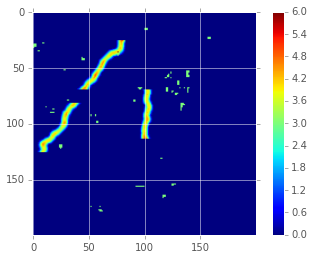

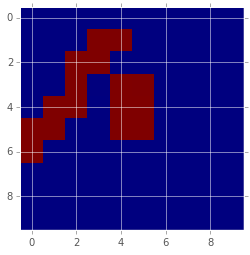

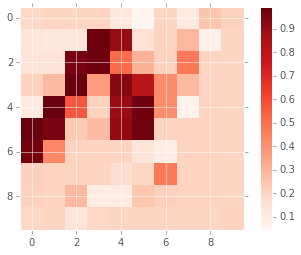

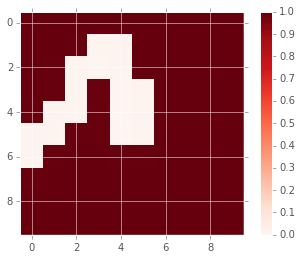

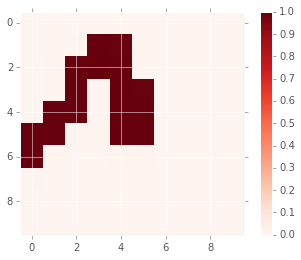

In [36]:
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((10, 10)), interpolation='none')
plt.show()

prediction = base.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(10, 10), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

In [45]:
np.prod(np.array((2, 3)))

6

In [46]:
tuple(np.array((2, 3)))

(2, 3)